May: **Research Questions 2.2** (Ideal and Real)

# Which of the three upwelling mechanisms (time dependence, advection, convergence of isobaths, coastal trapped wave) provides the strongest contribution to upwelling in Mackenzie Canyon?

At what depths does maximum upwelling occur?

(48 hrs) 46 min 

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

In [2]:
def get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile):

    start_time = datetime.now() 

    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 
                                                                            dep_ind, time_s, time_f, None)
    max_vosaline = np.full([vosaline.shape[0]], np.nan)
    min_vosaline = np.full([vosaline.shape[0]], np.nan)
    
    for t in range(vosaline.shape[0]):
        max_vosaline[t] = np.nanmax(vosaline[t, :, :])
        min_vosaline[t] = np.nanmin(vosaline[t, :, :])
        
    max_depth_ind = upwelling_functions.get_daily_depth_ind(max_vosaline, vosaline_ref_profile)
    max_depth_m, max_depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind, max_depth_ind, tmask)
    
    min_depth_ind = upwelling_functions.get_daily_depth_ind(min_vosaline, vosaline_ref_profile)
    min_depth_m, min_depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind, min_depth_ind, tmask)

    time_elapsed = datetime.now() - start_time 
    print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
        
    return max_depth_upwelled, min_depth_upwelled, sozotaux, deptht, tmask

In [3]:
def plot_axes(axes, n, max_depth_upwelled, min_depth_upwelled, tmask, deptht, dep_ind, time_s, time_f):
    xs = np.arange(tmask.shape[-1])
    ys = np.arange(tmask.shape[-2])
    ts = np.arange(time_s+1, time_f+1)
    
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

    p = axes[n, 0].pcolormesh(xs, ys, tmask, cmap=cmap)
    axes[n, 0].set_xlim([0, xs[-1]])
    axes[n, 0].set_ylim([0, ys[-1]])
    axes[n, 0].set_title('depth ' + str(int(round(int(deptht[dep_ind])))) +' m', fontsize=20)
    axes[n, 0].set_aspect(aspect='equal')
    
    axes[n, 1].plot(ts, min_depth_upwelled, c='steelblue', lw=2, label='downwelling')
    axes[n, 1].plot(ts, max_depth_upwelled, c='tomato', lw=2, label='upwelling')
    axes[n, 1].axhline(0, c='k', lw=2, linestyle='--')
    axes[n, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
    axes[n, 1].set_ylim([-50, 200])
    axes[n, 1].set_xlim([0, ts[-1]])
    axes[n, 1].legend(ncol=2, loc=1, fontsize=15)
    
    return

In [4]:
def execute_functions(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile, kind, case):

    fig, axes = plt.subplots(4, 2, figsize=(20, 12), gridspec_kw={"width_ratios":[1, 3]})
    fig.tight_layout(w_pad=0.5, h_pad=2)

    for n, dep_ind in zip(np.arange(1, len(dep_inds)+1), dep_inds):
        max_depth_upwelled, min_depth_upwelled, sozotaux, deptht, tmask = get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile)
        plot_axes(axes, n, max_depth_upwelled, min_depth_upwelled, tmask, deptht, dep_ind, time_s, time_f)

    ts = np.arange(time_s+1, time_f+1)
    axes[0, 0].remove()
    axes[0, 1].plot(ts, sozotaux, c='k', lw=2)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 23))
    axes[0, 1].set_title('Wind Stress [$Nm^{-2}$]', fontsize=20)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
    axes[0, 1].set_xlim([0, ts[-1]])
    plt.subplots_adjust(top=0.90)
    fig.suptitle(kind+' - '+case+': '+' hourly maximum vertical displacement [m]', fontsize=30)

    fig.savefig('../writing_images/displaced_max_time_series_'+kind+'_'+case+'.png', dpi=100, bbox_inches='tight')
    
    return

# Constants

In [5]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

time_s = 0 # python count
time_f = 10*24 # python count
dep_inds = [1, 9, 16]

# Ideal

Time elapsed (hh:mm:ss.ms) 0:00:12.243373
Time elapsed (hh:mm:ss.ms) 0:00:12.240428
Time elapsed (hh:mm:ss.ms) 0:00:12.470000


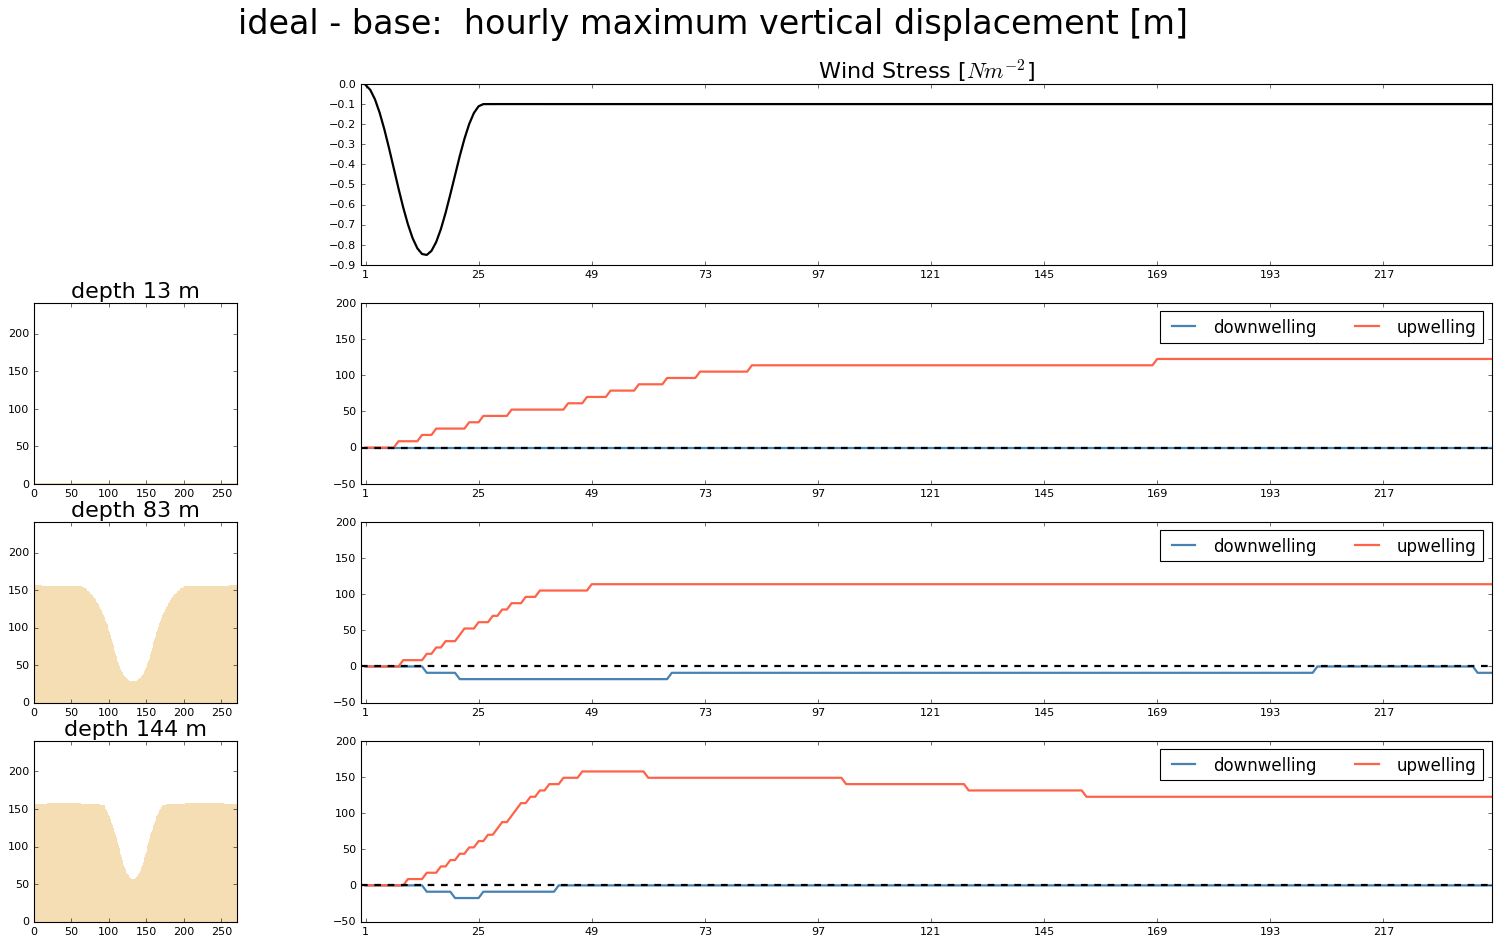

In [6]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
execute_functions(dirname, fname, meshmaskname, dep_inds, time_s, time_f, vosaline_ref_profile, kind, case)

# Real

Time elapsed (hh:mm:ss.ms) 0:00:12.632828
Time elapsed (hh:mm:ss.ms) 0:00:12.825858
Time elapsed (hh:mm:ss.ms) 0:00:12.676716


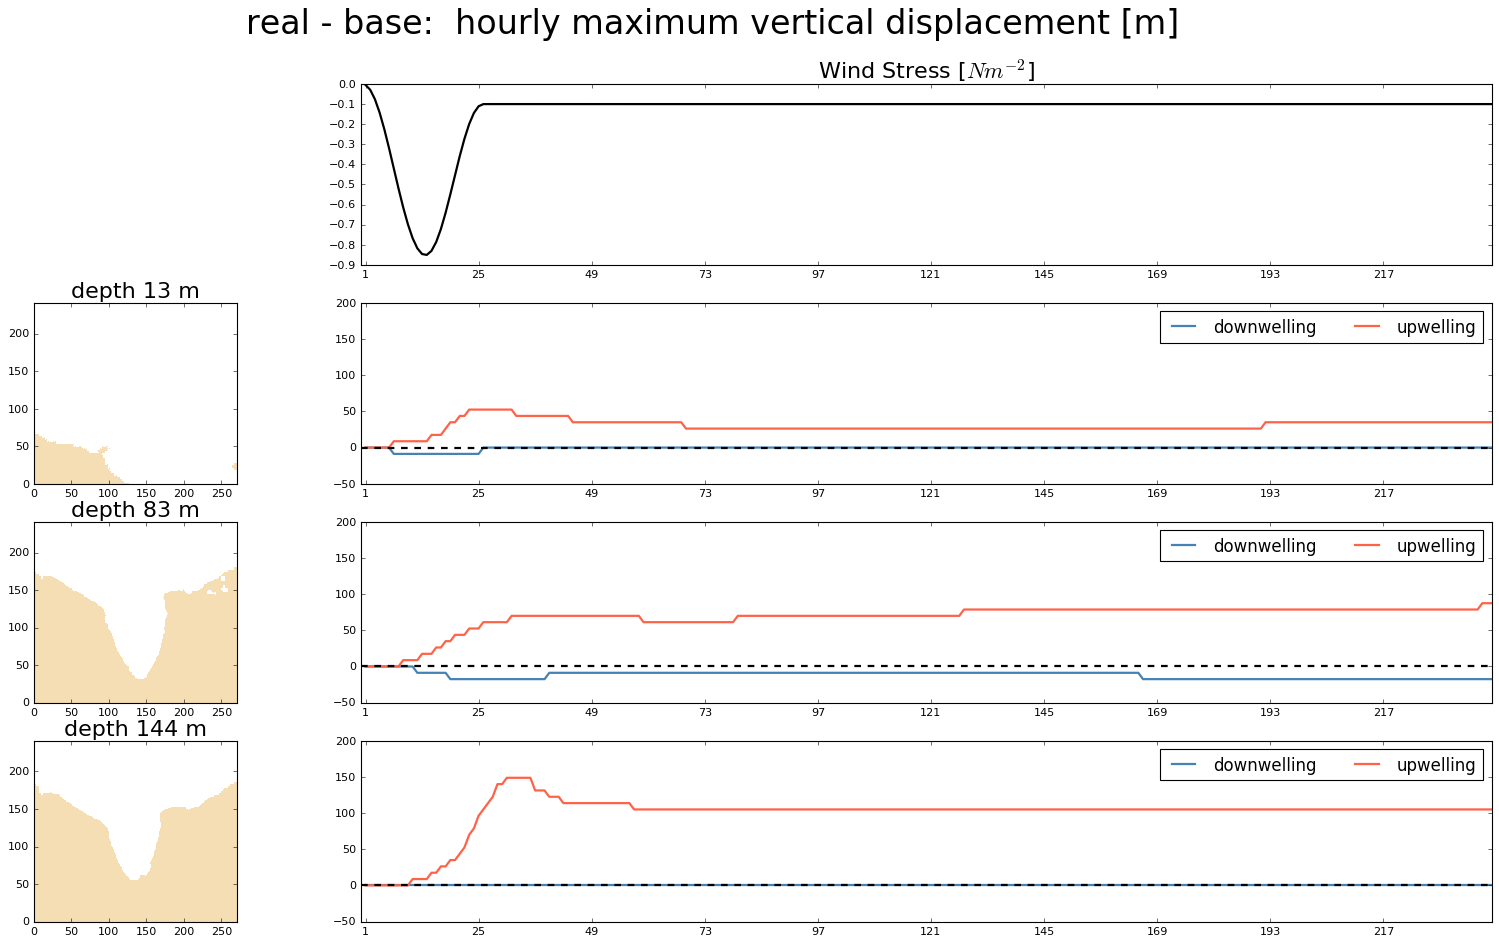

In [7]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
execute_functions(dirname, fname, meshmaskname, dep_inds, time_s, time_f, vosaline_ref_profile, kind, case)